In [ ]:
import dhfcorr.io.data_reader as dr
import dhfcorr.selection.selection as sl
import dhfcorr.qa as qa

import pandas as pd
import numpy as np

random_seed_global = 2303

%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import h2o

In [ ]:
variables_to_train = ['NormDecayLengthXY','CosP','CosPXY', 'ImpParXY', 'DCA', 
                      'Normd0MeasMinusExp','PtDaughter0', 'PtDaughter1', 'ReducedChi2', 'D0Prod','CosTs',
                      'D0Daughter0', 'D0Daughter1', 'DecayLength', 'DecayLengthXY', 'NormDecayLength', 
                      'NSigmaTPCDaughter0', 'NSigmaTOFDaughters0', 'NSigmaTPCDaughter1', 'NSigmaTOFDaughters1',
                      'SelectionStatusDefaultPID']

variables_to_keep = variables_to_train + ['InvMass', 'Pt', 'Eta', 'IsD', 'IsParticleCandidate', 'IsParticle'] 

bins = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10., 12., 16., np.inf]

d_cuts = sl.Cuts(None, 'D0')

# Get the data for background and signal

In [ ]:
def get_signal():
    
    d_mesons_mc = dr.load('D0_mc','d_meson')
    print(d_mesons_mc.columns)
    d_mesons_mc = sl.get_true_dmesons(d_mesons_mc)
    
    d_mesons_mc['PtBin'] = pd.cut(d_mesons_mc['Pt'],bins=bins)
    
    return d_mesons_mc

In [ ]:
signal = get_signal()

In [ ]:
mc_shape = signal.groupby('PtBin')['InvMass'].agg({'mean','std'}).reset_index()
mc_shape['PtMin'] = mc_shape['PtBin'].apply(lambda x: x.left).astype(np.float)
mc_shape['PtMax'] = mc_shape['PtBin'].apply(lambda x: x.right).astype(np.float)
mc_shape['PtMid'] = mc_shape['PtBin'].apply(lambda x: x.mid).astype(np.float)
mc_shape['XErr'] = mc_shape['PtBin'].apply(lambda x: x.length/2.).astype(np.float)
mc_shape.set_index('PtBin',inplace=True)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(x=mc_shape['PtMid'].values, y=mc_shape['mean'].values, xerr=mc_shape['XErr'].values, yerr=mc_shape['std'].values, fmt='o')
ax.set_xlabel('$p_{T}$ [GeV/$c$]')
ax.set_ylabel('Invariant Mass [GeV]')

In [ ]:
mc_shape.reset_index(drop=True).to_parquet('mc_mean_sigma.parquet')

In [ ]:
number_of_signal_particles = signal.groupby(by='PtBin')['Pt'].count()
number_of_signal_particles

In [139]:
def get_bkg(n_sigma = 4.0, n_bkg = 1.0, config='D0'):
    
    print("Reading dataset for bkg")
    bkg = dr.load(config,'d_meson')    
    
    print("Divinding into Pt Bins")
    # Divide in Pt Bins
    bkg['PtBin'] = pd.cut(bkg['Pt'],bins=bins)
    bkg.dropna('index',inplace=True)
    
    print("Rejecting particles in the signal region")
    # Get the mass limits to reject signal reagion
    limits = mc_shape.loc[bkg['Pt']].reset_index(drop=True)
    inv_mass_no_index = bkg['InvMass'].reset_index(drop=True)
    bkg.reset_index(drop=True, inplace=True)

    smaller = inv_mass_no_index < (limits['mean']-n_sigma*limits['std'])
    greater = inv_mass_no_index > (limits['mean']+n_sigma*limits['std'])
    bkg = bkg[smaller|greater]
    
    print("Reducing total number of background for training")
    filtered = bkg.groupby(by='PtBin').apply(lambda x: x.head(2*number_of_signal_particles.loc[x.name]))
    
    return filtered.reset_index(drop=True)

In [ ]:
background = get_bkg()

In [ ]:
background.groupby(by='PtBin')['Pt'].count()

In [ ]:
background['IsD'] = False
background['IsParticle'] = False

In [ ]:
dataset = pd.concat([background[variables_to_keep],signal[variables_to_keep]])

In [ ]:
del background, signal

In [ ]:
for col in dataset.columns:
    if dataset[col].dtype == np.float64:
        dataset[col] = dataset[col].astype(np.float32)

In [ ]:
dataset.drop('PtBin', axis='columns').to_parquet('ml_datasets/train_pp13TeV.parquet')

In [3]:
dataset = pd.read_parquet('ml_datasets/train_pp13TeV.parquet')

In [4]:
dataset['PtBin'] = pd.cut(dataset['Pt'], bins=bins)
def sample(x, n):
    if len(x) < n :
        return x
    else:
        return x.sample(n)
subset = dataset.groupby(by='PtBin').apply(lambda x: sample(x,600000))

In [5]:
subset.reset_index(drop=True,inplace=True)

In [6]:
subset.groupby(by='PtBin')['Pt'].count()

PtBin
(2.0, 3.0]      600000
(3.0, 4.0]      600000
(4.0, 5.0]      600000
(5.0, 6.0]      600000
(6.0, 7.0]      600000
(7.0, 8.0]      600000
(8.0, 10.0]     600000
(10.0, 12.0]    343873
(12.0, 16.0]    283061
(16.0, inf]     173623
Name: Pt, dtype: int64

In [7]:
del dataset
dataset = subset

In [8]:
h2o.init(max_mem_size='20G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_211"; Java(TM) SE Runtime Environment (build 1.8.0_211-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from /Users/hzanoli/Library/Python/3.7/lib/python/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4t/zk1rccns5072p70dx_nkmx300000gn/T/tmpk_fenkg9
  JVM stdout: /var/folders/4t/zk1rccns5072p70dx_nkmx300000gn/T/tmpk_fenkg9/h2o_hzanoli_started_from_python.out
  JVM stderr: /var/folders/4t/zk1rccns5072p70dx_nkmx300000gn/T/tmpk_fenkg9/h2o_hzanoli_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Amsterdam
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.4
H2O cluster version age:,2 months and 8 days
H2O cluster name:,H2O_from_python_hzanoli_lcmcp2
H2O cluster total nodes:,1
H2O cluster free memory:,17.78 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [9]:
rf_models = list()
dataframes_h20 = list()
test_frames = list()
performance_model = list()


for name, data in dataset.groupby(by='PtBin'):
    
    data = data.drop('PtBin',axis='columns')
    split = 0.5
    
    data.to_parquet('temp.parquet')
    file = 'temp.parquet'
    
    covtype_df = h2o.import_file(file)
    
    covtype_df['IsD'] = covtype_df['IsD'].asfactor()
    
    dataframes_h20.append(covtype_df)
    
    covtype_X = variables_to_train
    covtype_y = 'IsD'
    
    train, test = covtype_df.split_frame([split], seed=1234)
    test_frames.append(test)
    
    parameters = {'ntrees': 850,
                  'min_child_weight': 3,
                  'max_depth': 4,
                  'gamma': 0.,
                  'sample_rate': 0.8,
                  'col_sample_rate': 0.3,
                  'learn_rate': 0.1}
    
    rf_v1 = h2o.estimators.xgboost.H2OXGBoostEstimator(**parameters)    
    rf_v1.train(covtype_X, covtype_y, training_frame=train)
    
    rf_models.append(rf_v1)
    perf = rf_v1.model_performance(test_data=test)
    performance_model.append(perf)

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |███████████

In [112]:
import importlib
importlib.reload(sl)

<module 'dhfcorr.selection.selection' from '/Users/hzanoli/cernbox/postdoc/DHFeCorrLocal/dhfcorr/selection/selection.py'>

Compare to default cuts

In [113]:
selection_for_ptbin = sl.Cuts('cuts_jets.yaml')

filtered = list()
for test,i in zip(test_frames,range(len(test_frames))):
    df = test.as_data_frame()
    selected = sl.filter_in_pt_bins(df,selection_for_ptbin)
    filtered.append(selected)

0
0
17829
0
0
0
0
0
0
0
0
0
0
17829
0
0
0
29578
0
0
0
0
0
0
0
0
0
29578
0
0
0
0
61084
0
0
0
0
0
0
0
0
61084
0
0
0
0
0
106607
0
0
0
0
0
0
0
106607
0
0
0
0
0
0
133385
0
0
0
0
0
0
133385
0
0
0
0
0
0
0
145389
0
0
0
0
0
145389
0
0
0
0
0
0
0
0
173531
0
0
0
0
173531
0
0
0
0
0
0
0
0
0
101254
0
0
0
101254
0
0
0
0
0
0
0
0
0
0
94677
0
0
94677
0
0
0
0
0
0
0
0
0
0
0
46088
10800
56888


In [121]:
filtered[0].columns

Index(['NormDecayLengthXY', 'CosP', 'CosPXY', 'ImpParXY', 'DCA',
       'Normd0MeasMinusExp', 'PtDaughter0', 'PtDaughter1', 'ReducedChi2',
       'D0Prod', 'CosTs', 'D0Daughter0', 'D0Daughter1', 'DecayLength',
       'DecayLengthXY', 'NormDecayLength', 'NSigmaTPCDaughter0',
       'NSigmaTOFDaughters0', 'NSigmaTPCDaughter1', 'NSigmaTOFDaughters1',
       'SelectionStatusDefaultPID', 'InvMass', 'Pt', 'Eta', 'IsD',
       'IsParticleCandidate', 'IsParticle', '__index_level_0__'],
      dtype='object')

In [127]:
def signal_efficiency(before,after):
    n_before = len(before[before['IsD']=='1'])
    n_after = len(after[after['IsD']==True])
    return float(n_after/n_before)

def bkg_efficiency(before,after):
    n_before = len(before[before['IsD']=='0'])
    n_after = len(after[after['IsD']==False])
    
    return float(n_after/n_before)

def calculate_efficiencies(before,after):
    return (signal_efficiency(before,after),bkg_efficiency(before,after))

In [128]:
bkg_eff = list()
signal_eff = list()

for before, after in zip(test_frames,filtered):
    effs = calculate_efficiencies(before,after)
    signal_eff.append(effs[0])
    bkg_eff.append(effs[1])

In [130]:
predictions = list()
for frame,model in zip(test_frames, rf_models):
    prediction = model.predict(frame)
    frame['prob'] = prediction['p1']
    predictions.append(prediction)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,0.994392,0.00560758
0,0.999758,0.000242416
1,0.554001,0.445999
1,0.00296915,0.997031
0,0.998571,0.0014291
0,0.924393,0.0756066
1,0.0266766,0.973323
1,0.212212,0.787788
0,0.878747,0.121253
1,0.482129,0.517871



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.52193,0.47807
0,0.999997,2.57358e-06
1,0.0193246,0.980675
1,0.00323761,0.996762
0,0.800071,0.199929
0,0.999769,0.000231057
1,0.0291204,0.97088
1,0.0251017,0.974898
1,0.00911403,0.990886
1,0.345831,0.654169



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,0.999982,1.83137e-05
0,0.995201,0.00479937
1,0.0399884,0.960012
1,0.314911,0.685089
0,0.999944,5.56491e-05
0,0.999978,2.15178e-05
0,0.999524,0.000475687
1,0.0656714,0.934329
1,0.138042,0.861958
0,0.99971,0.000289757



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,0.931713,0.0682869
1,0.145951,0.854049
1,0.011506,0.988494
1,0.0663239,0.933676
0,0.999862,0.000137494
1,0.0762002,0.9238
0,0.99961,0.000390207
1,0.0385098,0.96149
1,0.00787055,0.992129
0,0.998447,0.00155266



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.0160832,0.983917
1,0.0100622,0.989938
1,0.00969458,0.990305
1,0.067044,0.932956
1,0.0332791,0.966721
1,0.0136169,0.986383
0,0.906599,0.0934007
1,0.00412178,0.995878
1,0.231044,0.768956
1,0.270272,0.729728



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.0139832,0.986017
1,0.00143498,0.998565
1,0.0153727,0.984627
1,0.0799479,0.920052
0,0.768686,0.231314
1,0.0163659,0.983634
1,0.00743872,0.992561
0,0.589078,0.410922
1,0.272851,0.727149
1,0.00377029,0.99623



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.0275033,0.972497
1,0.00556469,0.994435
1,0.357088,0.642912
1,0.0111343,0.988866
1,0.00481659,0.995183
1,0.00898254,0.991017
1,0.0302671,0.969733
1,0.00664771,0.993352
1,0.00514716,0.994853
1,0.005,0.995



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,1,3.59188e-08
0,0.996433,0.00356698
0,0.995687,0.00431326
0,0.964368,0.0356325
1,0.020449,0.979551
0,0.886533,0.113467
0,0.969489,0.0305106
0,0.957225,0.0427754
0,0.704549,0.295451
0,0.745026,0.254974



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.145051,0.854949
1,0.061851,0.938149
1,0.12535,0.87465
0,0.961116,0.0388836
0,0.998852,0.00114795
1,0.00494468,0.995055
1,0.00407541,0.995925
0,0.995078,0.00492231
0,0.551243,0.448757
1,0.240136,0.759864



xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
0,0.427145,0.572855
0,0.985203,0.0147975
1,0.378635,0.621365
0,0.992177,0.0078234
1,0.254682,0.745318
0,0.515358,0.484642
0,0.992369,0.0076307
0,0.662915,0.337085
1,0.0128455,0.987154
0,0.484713,0.515287


In [143]:
rf_models[0]

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1565097517577_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.050209560395831604
RMSE: 0.2240748990758037
LogLoss: 0.16703826399651084
Mean Per-Class Error: 0.07070759998501153
AUC: 0.9820896299018634
pr_auc: 0.9437009169212855
Gini: 0.9641792598037269
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.434690458954667: 


,0,1,Error,Rate
0,188030.0,11755.0,0.0588,(11755.0/199785.0)
1,8917.0,91598.0,0.0887,(8917.0/100515.0)
Total,196947.0,103353.0,0.0688,(20672.0/300300.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4346905,0.8986011,212.0
max f2,0.2274149,0.9284647,279.0
max f0point5,0.6746422,0.9144964,138.0
max accuracy,0.4701339,0.9315684,201.0
max precision,0.9981944,0.9995870,1.0
max recall,0.0026139,1.0,395.0
max specificity,0.9989593,0.9999950,0.0
max absolute_mcc,0.4448412,0.8467062,209.0
max min_per_class_accuracy,0.3833803,0.9286176,228.0
max mean_per_class_accuracy,0.3535282,0.9292924,237.0


Gains/Lift Table: Avg response rate: 33.47 %, avg score: 33.47 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.9983394,2.9866189,2.9866189,0.9996670,0.9988383,0.9996670,0.9988383,0.0298662,0.0298662,198.6618913,198.6618913
,2,0.02,0.9974979,2.9836343,2.9851266,0.9986680,0.9979223,0.9991675,0.9983803,0.0298363,0.0597025,198.3634283,198.5126598
,3,0.03,0.9965808,2.9796548,2.9833027,0.9973360,0.9970575,0.9985570,0.9979394,0.0297965,0.0894991,197.9654778,198.3302658
,4,0.04,0.9955173,2.9846292,2.9836343,0.9990010,0.9960574,0.9986680,0.9974689,0.0298463,0.1193454,198.4629160,198.3634283
,5,0.05,0.9943212,2.9786599,2.9826394,0.9970030,0.9949387,0.9983350,0.9969628,0.0297866,0.1491320,197.8659902,198.2639407
,6,0.1,0.9838894,2.9752773,2.9789584,0.9958708,0.9899106,0.9971029,0.9934367,0.1487639,0.2978958,197.5277322,197.8958364
,7,0.15,0.9587028,2.9462269,2.9680479,0.9861472,0.9729722,0.9934510,0.9866152,0.1473113,0.4452072,194.6226931,196.8047887
,8,0.2000033,0.9013111,2.8692314,2.9433425,0.9603756,0.9335914,0.9851817,0.9733586,0.1434711,0.5886783,186.9231383,194.3342527
,9,0.3,0.6094357,2.4821998,2.7896334,0.8308302,0.7760714,0.9337329,0.9075984,0.2482117,0.8368900,148.2199754,178.9633388
,10,0.4,0.2483699,1.2696612,2.4096404,0.4249750,0.4176651,0.8065435,0.7851150,0.1269661,0.9638561,26.9661245,140.9640352



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-08-06 15:18:54,0.184 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.6652847
,2019-08-06 15:18:56,1.912 sec,1.0,0.4782890,0.6505836,0.8522248,0.2198491,2.3212028,0.1882218
,2019-08-06 15:18:56,2.607 sec,2.0,0.4593544,0.6146527,0.8762144,0.3063535,2.6099832,0.1975225
,2019-08-06 15:18:57,3.194 sec,3.0,0.4443536,0.5867300,0.8802608,0.3429452,2.6512428,0.1898868
,2019-08-06 15:18:57,3.768 sec,4.0,0.4298357,0.5600565,0.8830728,0.3677767,2.7134122,0.1856377
---,---,---,---,---,---,---,---,---,---
,2019-08-06 15:21:30,2 min 36.583 sec,468.0,0.2371928,0.1861173,0.9776265,0.9502926,2.9856247,0.0779088
,2019-08-06 15:21:51,2 min 57.868 sec,533.0,0.2336846,0.1809748,0.9789204,0.9436490,2.9866189,0.0757043
,2019-08-06 15:22:20,3 min 26.052 sec,606.0,0.2310376,0.1770736,0.9798252,0.9440688,2.9856247,0.0733833
,2019-08-06 15:22:59,4 min 5.470 sec,705.0,0.2277342,0.1722859,0.9809328,0.9442354,2.9866189,0.0714186



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NormDecayLengthXY,178029.0781250,1.0,0.1489333
D0Prod,162267.4375000,0.9114659,0.1357477
NSigmaTOFDaughters1,110015.2578125,0.6179623,0.0920352
DCA,108758.0625000,0.6109006,0.0909835
NSigmaTPCDaughter1,94736.3046875,0.5321395,0.0792533
---,---,---,---
Normd0MeasMinusExp,11684.8330078,0.0656344,0.0097752
D0Daughter1,9593.5898438,0.0538878,0.0080257
D0Daughter0,9003.6748047,0.0505742,0.0075322
ImpParXY,7863.9448242,0.0441722,0.0065787



See the whole table with table.as_data_frame()


In [141]:
pt_bins = pd.Series(pd.cut(filtered[0]['Pt'], bins=bins).cat.categories)

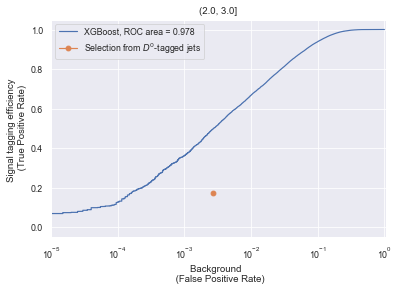

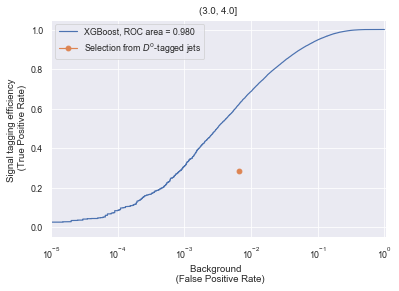

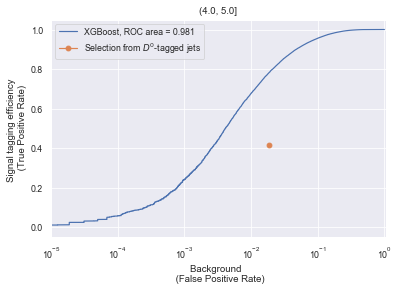

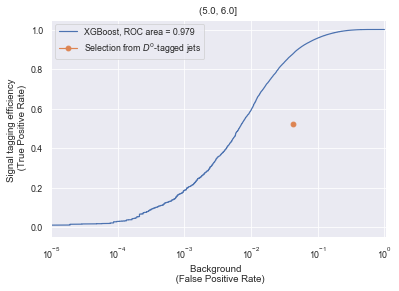

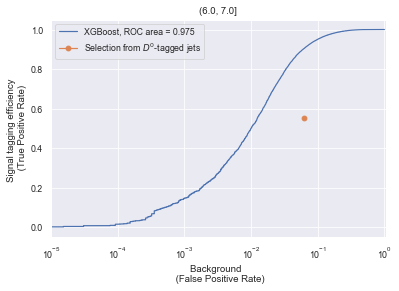

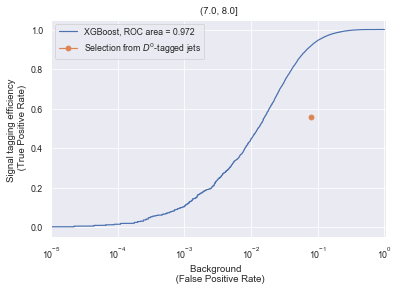

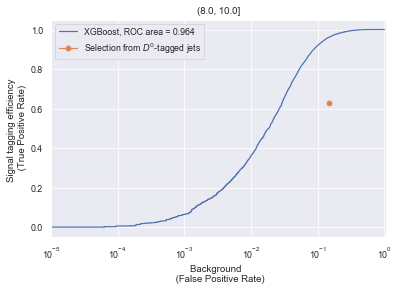

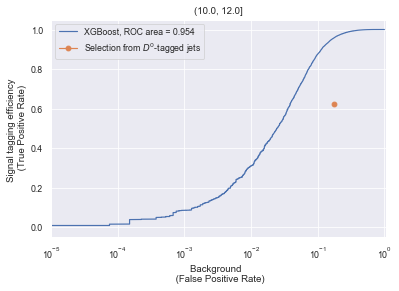

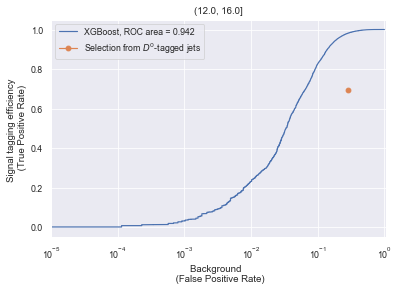

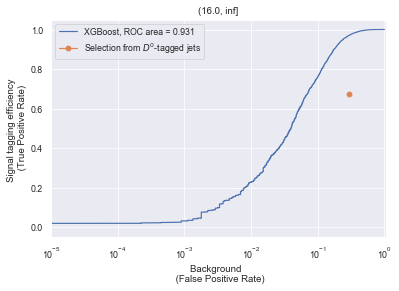

In [152]:
from sklearn.metrics import roc_curve, auc

sns.set_context('paper')

background_optimization = list()
for test, perf, i in zip(test_frames, performance_model, range(len(test_frames))):

    fig, ax = plt.subplots()
    
    y_test = test['IsD'].as_data_frame()
    decisions =  test['prob'].as_data_frame()
    
    bkg, sig, thresholds = roc_curve(y_test, decisions,drop_intermediate=False)
    background_optimization_local = pd.DataFrame(np.array([bkg, sig, thresholds]).T, 
                                                 columns=['bkg','signal','bdt_cut'])

    background_optimization.append(background_optimization_local)
    roc_auc = auc(bkg, sig)
    
    title = str(pt_bins.iloc[i])
    
    ax.plot(bkg, sig, label='XGBoost, ROC area = %0.3f'%roc_auc)

    ax.set_xlim([1e-5, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xscale('log')
    ax.set_xlabel('Background  \n (False Positive Rate)')
    ax.set_ylabel('Signal tagging efficiency \n (True Positive Rate)')
    ax.set_title(title)
    ax.plot(bkg_eff[i],signal_eff[i], marker='o', label='Selection from $D^{0}$-tagged jets')
    
    ax.legend()
    
    fig.savefig('performace_'+title+ '.pdf',bbox_inches='tight')

In [145]:
for model, i in zip(rf_models, range(len(rf_models))):
    name = model.download_mojo(path="~/cernbox/postdoc/DHFeCorrLocal/mojo/", get_genmodel_jar=True)
    model_path = h2o.save_model(model=model, path="~/cernbox/postdoc/DHFeCorrLocal/mojo/", force=True)

    import os
    os.rename(name, os.path.dirname(name)+'/pt_'+str(i)+'.zip')
    os.rename(model_path, os.path.dirname(name)+'/h2o_pt_'+str(i))

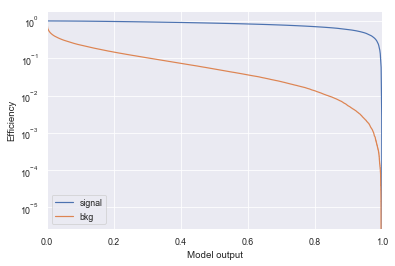

In [146]:
ax = background_optimization[0].plot(x='bdt_cut', y=['signal', 'bkg'])
ax.set_ylabel('Efficiency')
ax.set_xlabel('Model output')
ax.set_xlim(1e-6,1)
ax.set_yscale('log')

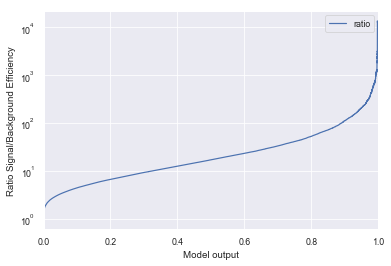

In [147]:
background_optimization[0]['ratio'] = background_optimization[0]['signal']/background_optimization[0]['bkg']
ax = background_optimization[0].plot(x= 'bdt_cut', y=['ratio'])
ax.set_ylabel('Ratio Signal/Background Efficiency')
ax.set_xlabel('Model output')
ax.set_xlim([0,1])
ax.set_yscale('log')

In [148]:
best_models = background_optimization[0][ (background_optimization[0]['bkg']<bkg_eff[0]) & 
                                         (background_optimization[0]['signal']>signal_eff[0])].copy()

best_models['gain_signal'] = best_models['signal']/signal_eff[0]
best_models['bkg_signal'] = best_models['bkg']/bkg_eff[0]

In [149]:
def get_best_model_cut(index):
    background_optimization[index]['ratio'] = background_optimization[index]['signal']/background_optimization[index]['bkg']
    best = background_optimization[index][(background_optimization[index]['ratio']> (signal_eff[index]/bkg_eff[index]) ) & 
                                          (background_optimization[index]['signal']>signal_eff[index])].copy()
    best['gain_signal'] = best['signal']/signal_eff[index]
    best['gain_bkg'] = best['bkg']/bkg_eff[index]
    return best.replace(np.inf, 0.).sort_values('signal',ascending=False).iloc[0]['bdt_cut']

In [150]:
values_to_cut = [get_best_model_cut(i) for i in range(len(background_optimization))]

In [151]:
values_to_cut

[0.8295304179191589,
 0.758073091506958,
 0.6754142045974731,
 0.6611857414245605,
 0.6925405859947205,
 0.7011485099792479,
 0.5940353274345398,
 0.6296995282173157,
 0.4826835691928864,
 0.5925767421722412]